In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, train_surrogate_tree, plot_surrogate_tree,\
                           extract_rules, print_rules, evaluate_generated_data,\
                           evaluate, plot_tree_leafs_2d, plot_diro2c_2d, get_surrogate_tree,\
                           get_feature_importances, plot_feature_importances, search_max_depth_parameter
from util import RuleClassifier, evaluate_counterfactual_fidelity, get_complexity
from util import evaluate as evaluate_ruleclf
from tasks.boston_housing import make_task4 as make_task

In [2]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task()

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Explanations

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

## $(0,1)$

In [124]:
focus_class = '(0, 1)'
focus_class_idx = list(comparer.class_names).index(focus_class)
y_true = mclass_diff == focus_class_idx

In [9]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 10min 9s, sys: 7.74 s, total: 10min 17s
Wall time: 11min 6s


In [125]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [126]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

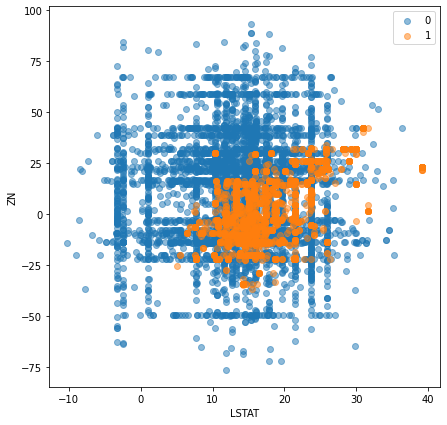

In [127]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### Find Optimal Solution

In [128]:
%%time
metrics = search_max_depth_parameter(explanation, X, y_true=y_true)

CPU times: user 39.3 s, sys: 373 ms, total: 39.7 s
Wall time: 42.1 s


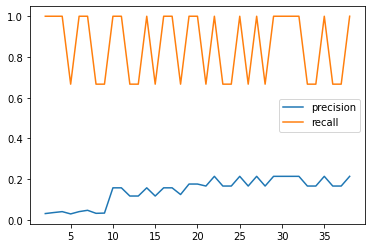

In [129]:
metrics.loc[:, ('precision', 'recall')].plot();

Parameter setting 4 is the one with highest precision and recall with only one rule. Setting 10 significantly increases precision with an additional rule.

In [130]:
metrics[metrics['recall'] > 0.9]

,precision,recall,rules,constraints
2,0.031579,1.0,1,2
3,0.036585,1.0,1,3
4,0.041096,1.0,1,4
6,0.041096,1.0,2,12
7,0.047619,1.0,2,13
10,0.157895,1.0,2,17
11,0.157895,1.0,2,18
14,0.157895,1.0,2,19
16,0.157895,1.0,2,18
17,0.157895,1.0,2,19


### Global Explanation

In [12]:
%%time
train_surrogate_tree(explanation, max_depth=4)

CPU times: user 66.4 ms, sys: 4.15 ms, total: 70.6 ms
Wall time: 84.9 ms


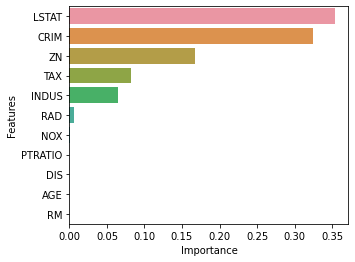

In [13]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 4))

In [26]:
y = (y_true).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
len(rules)

7

In [27]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

8      1
40     1
238    1
dtype: int64

In [28]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. CRIM <= 3.9374778270721436 and ZN <= 14.453744888305664 and 8.299129009246826 < LSTAT <= 24.16856861114502 [814, 8000]


In [29]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.98      0.92      0.95     18123
           1       0.89      0.97      0.93     11709

    accuracy                           0.94     29832
   macro avg       0.94      0.95      0.94     29832
weighted avg       0.95      0.94      0.94     29832



#### Evaluation

##### Global Fidelity

In [30]:
rclf = RuleClassifier(feature_names, rules)
evaluate_ruleclf(rclf, X, y_true)

              precision    recall  f1-score   support

       False       1.00      0.71      0.83       243
        True       0.04      1.00      0.08         3

    accuracy                           0.72       246
   macro avg       0.52      0.86      0.46       246
weighted avg       0.99      0.72      0.82       246



##### Counterfactual Fidelity Error

In [31]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [32]:
rmse

CRIM        2.031954
ZN         14.128278
INDUS            NaN
NOX              NaN
RM               NaN
AGE              NaN
DIS              NaN
RAD              NaN
TAX              NaN
PTRATIO          NaN
LSTAT       8.180692
dtype: float64

In [33]:
boundary_miss_rate

CRIM       0.4
ZN         0.0
INDUS      1.0
NOX        NaN
RM         1.0
AGE        1.0
DIS        1.0
RAD        1.0
TAX        1.0
PTRATIO    1.0
LSTAT      0.0
dtype: float64

In [34]:
boundary_add_rate

CRIM       0.0
ZN         0.0
INDUS      NaN
NOX        NaN
RM         NaN
AGE        NaN
DIS        NaN
RAD        NaN
TAX        NaN
PTRATIO    NaN
LSTAT      0.0
dtype: float64

##### Complexity

In [35]:
get_complexity(constraints)

Number of rules: 1
Number of constraints: 4 (4.0 per rule)


### Local Explanation

In [131]:
%%time
train_surrogate_tree(explanation, max_depth=10)

CPU times: user 127 ms, sys: 4.07 ms, total: 131 ms
Wall time: 172 ms


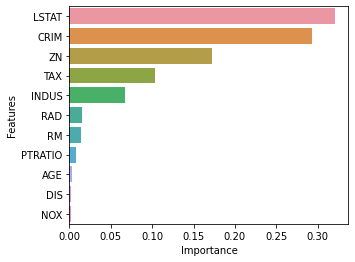

In [132]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 4))

In [133]:
y = (y_true).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
len(rules)

86

In [134]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

8      45
40      3
238     3
dtype: int64

In [135]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. CRIM <= 3.9374778270721436 and -35.12996482849121 < ZN <= 14.453744888305664 and INDUS > 4.032393932342529 and RM > 4.480623245239258 and TAX <= 629.3493041992188 and 8.299129009246826 < LSTAT <= 14.221139430999756 [160, 1219]
2. CRIM <= 3.9374778270721436 and ZN <= 14.453744888305664 and INDUS > 14.204819202423096 and AGE > 1.25583416223526 and TAX > 629.3493041992188 and PTRATIO > 12.388098239898682 and 8.299129009246826 < LSTAT <= 24.16856861114502 [0, 2]


In [136]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     18123
           1       0.95      0.99      0.97     11709

    accuracy                           0.98     29832
   macro avg       0.97      0.98      0.98     29832
weighted avg       0.98      0.98      0.98     29832



#### Evaluation

##### Global Fidelity

In [137]:
rclf = RuleClassifier(feature_names, rules)
evaluate_ruleclf(rclf, X, y_true)

              precision    recall  f1-score   support

       False       1.00      0.93      0.97       243
        True       0.16      1.00      0.27         3

    accuracy                           0.93       246
   macro avg       0.58      0.97      0.62       246
weighted avg       0.99      0.93      0.96       246



##### Counterfactual Fidelity Error

In [138]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [139]:
rmse

CRIM         2.031954
ZN          14.128278
INDUS        9.018509
NOX               NaN
RM           1.196248
AGE          0.255834
DIS               NaN
RAD               NaN
TAX        215.432451
PTRATIO      6.791902
LSTAT        5.141852
dtype: float64

In [140]:
boundary_miss_rate

CRIM       0.400000
ZN         0.000000
INDUS      0.500000
NOX             NaN
RM         0.666667
AGE        0.666667
DIS        1.000000
RAD        1.000000
TAX        0.250000
PTRATIO    0.833333
LSTAT      0.000000
dtype: float64

In [141]:
boundary_add_rate

CRIM       0.0
ZN         0.4
INDUS      0.0
NOX        NaN
RM         0.0
AGE        0.0
DIS        NaN
RAD        NaN
TAX        0.0
PTRATIO    0.0
LSTAT      0.0
dtype: float64

##### Complexity

In [142]:
get_complexity(constraints)

Number of rules: 2
Number of constraints: 16 (8.0 per rule)


## $(1,0)$

In [5]:
focus_class = '(1, 0)'
focus_class_idx = list(comparer.class_names).index(focus_class)
y_true = mclass_diff == focus_class_idx

In [14]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 9min 57s, sys: 6.88 s, total: 10min 4s
Wall time: 10min 36s


In [6]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [7]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

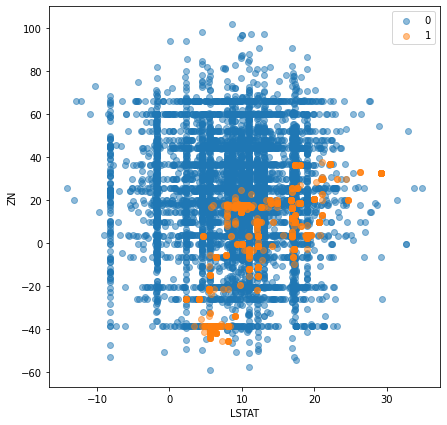

In [8]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### Find Optimal Solution

In [39]:
%%time
metrics = search_max_depth_parameter(explanation, X, y_true=y_true)

CPU times: user 11.6 s, sys: 105 ms, total: 11.8 s
Wall time: 12.3 s


The generated explanation does not explain the instances.

In [40]:
metrics

,precision,recall,rules,constraints


## $(1,2)$

In [55]:
focus_class = '(1, 2)'
focus_class_idx = list(comparer.class_names).index(focus_class)
y_true = mclass_diff == focus_class_idx

In [19]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 10min 8s, sys: 7.68 s, total: 10min 16s
Wall time: 11min 1s


In [56]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [57]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

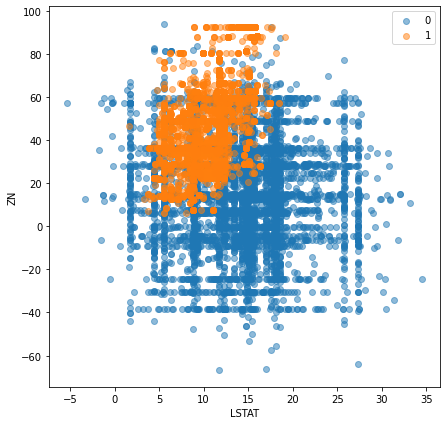

In [58]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### Find Optimal Solution

In [59]:
%%time
metrics = search_max_depth_parameter(explanation, X, y_true=y_true)

CPU times: user 42.4 s, sys: 282 ms, total: 42.7 s
Wall time: 43.2 s


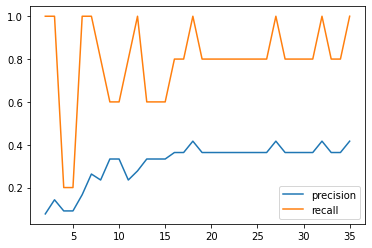

In [61]:
metrics.loc[:, ('precision', 'recall')].plot();

Parameter setting 3 yields one rule, to provide a global explanation, and 7 two rules, that provides local explanations with a higher precision.

In [62]:
metrics[metrics['recall'] > 0.9]

,precision,recall,rules,constraints
2,0.076923,1.0,1,2
3,0.142857,1.0,1,3
6,0.166667,1.0,2,10
7,0.263158,1.0,2,11
12,0.277778,1.0,3,27
18,0.416667,1.0,3,30
27,0.416667,1.0,3,28
32,0.416667,1.0,3,29
35,0.416667,1.0,3,29


### Global Explanation

In [63]:
%%time
train_surrogate_tree(explanation, max_depth=3)

CPU times: user 63.3 ms, sys: 2.89 ms, total: 66.2 ms
Wall time: 73.9 ms


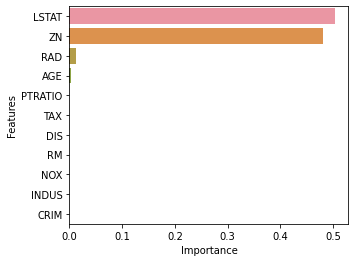

In [64]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 4))

In [65]:
y = (y_true).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
len(rules)

3

In [66]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

22     1
55     1
68     1
122    1
206    1
dtype: int64

In [67]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. ZN > 12.296755313873291 and 4.929397106170654 < LSTAT <= 14.296003818511963 [2942, 11030]


In [68]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.98      0.83      0.90     18214
           1       0.80      0.98      0.88     12785

    accuracy                           0.89     30999
   macro avg       0.89      0.90      0.89     30999
weighted avg       0.91      0.89      0.89     30999



#### Evaluation

##### Global Fidelity

In [69]:
rclf = RuleClassifier(feature_names, rules)
evaluate_ruleclf(rclf, X, y_true)

              precision    recall  f1-score   support

       False       1.00      0.88      0.93       241
        True       0.14      1.00      0.25         5

    accuracy                           0.88       246
   macro avg       0.57      0.94      0.59       246
weighted avg       0.98      0.88      0.92       246



##### Counterfactual Fidelity Error

In [70]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [71]:
rmse

CRIM             NaN
ZN         37.797274
INDUS            NaN
NOX              NaN
RM               NaN
AGE              NaN
DIS              NaN
RAD              NaN
TAX              NaN
PTRATIO          NaN
LSTAT       4.235779
dtype: float64

In [72]:
boundary_miss_rate

CRIM       1.000000
ZN         0.166667
INDUS      1.000000
NOX        1.000000
RM         1.000000
AGE        1.000000
DIS        1.000000
RAD        1.000000
TAX        1.000000
PTRATIO         NaN
LSTAT      0.000000
dtype: float64

In [73]:
boundary_add_rate

CRIM       NaN
ZN         0.0
INDUS      NaN
NOX        NaN
RM         NaN
AGE        NaN
DIS        NaN
RAD        NaN
TAX        NaN
PTRATIO    NaN
LSTAT      0.0
dtype: float64

##### Complexity

In [74]:
get_complexity(constraints)

Number of rules: 1
Number of constraints: 3 (3.0 per rule)


### Local Explanation

In [75]:
%%time
train_surrogate_tree(explanation, max_depth=7)

CPU times: user 105 ms, sys: 2.88 ms, total: 108 ms
Wall time: 113 ms


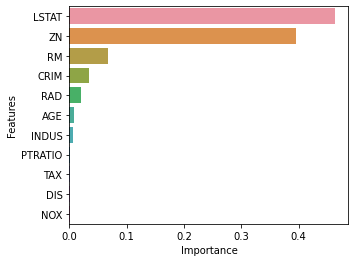

In [76]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 4))

In [77]:
y = (y_true).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
len(rules)

36

In [78]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

22     7
55     1
68     7
122    7
206    7
dtype: int64

In [79]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. CRIM > 0.34823232889175415 and ZN > 12.296755313873291 and 5.4463255405426025 < RM <= 7.675806999206543 and 4.929397106170654 < LSTAT <= 13.18403434753418 [643, 8901]
2. -1.2471919059753418 < CRIM <= 0.34823232889175415 and ZN > 30.986546516418457 and 4.929397106170654 < LSTAT <= 12.882936477661133 [33, 66]


In [80]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     18214
           1       0.92      0.99      0.95     12785

    accuracy                           0.96     30999
   macro avg       0.96      0.96      0.96     30999
weighted avg       0.96      0.96      0.96     30999



#### Evaluation

##### Global Fidelity

In [81]:
rclf = RuleClassifier(feature_names, rules)
evaluate_ruleclf(rclf, X, y_true)

              precision    recall  f1-score   support

       False       1.00      0.94      0.97       241
        True       0.26      1.00      0.42         5

    accuracy                           0.94       246
   macro avg       0.63      0.97      0.69       246
weighted avg       0.99      0.94      0.96       246



##### Counterfactual Fidelity Error

In [82]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [83]:
rmse

CRIM       28.637197
ZN         21.119867
INDUS            NaN
NOX              NaN
RM          1.125117
AGE              NaN
DIS              NaN
RAD              NaN
TAX              NaN
PTRATIO          NaN
LSTAT       3.421022
dtype: float64

In [84]:
boundary_miss_rate

CRIM       0.200000
ZN         0.166667
INDUS      1.000000
NOX        1.000000
RM         0.777778
AGE        1.000000
DIS        1.000000
RAD        1.000000
TAX        1.000000
PTRATIO         NaN
LSTAT      0.000000
dtype: float64

In [85]:
boundary_add_rate

CRIM       0.555556
ZN         0.000000
INDUS           NaN
NOX             NaN
RM         0.000000
AGE             NaN
DIS             NaN
RAD             NaN
TAX             NaN
PTRATIO         NaN
LSTAT      0.000000
dtype: float64

##### Complexity

In [86]:
get_complexity(constraints)

Number of rules: 2
Number of constraints: 11 (5.5 per rule)


## $(2,1)$

In [87]:
focus_class = '(2, 1)'
focus_class_idx = list(comparer.class_names).index(focus_class)
y_true = mclass_diff == focus_class_idx

In [24]:
%%time
explainer = WrappedDiro2C(X, comparer, focus_class)
explanation = explainer.generate_global_explanation()
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 9min 52s, sys: 6.77 s, total: 9min 59s
Wall time: 10min 27s


In [88]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [89]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

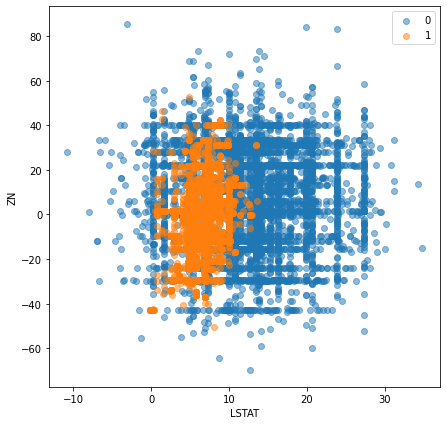

In [90]:
plot_diro2c_2d(explanation, 'LSTAT', 'ZN')

### Find Optimal Solution

In [91]:
%%time
metrics = search_max_depth_parameter(explanation, X, y_true=y_true)

CPU times: user 52.1 s, sys: 471 ms, total: 52.5 s
Wall time: 55 s


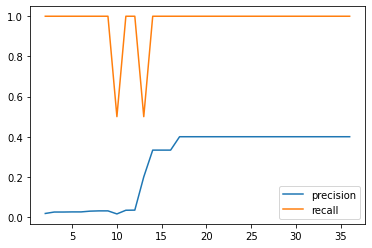

In [92]:
metrics.loc[:, ('precision', 'recall')].plot();

8 yields the best explanation with just one rule, while 14 is the first explanation that has much higher precision.

In [93]:
metrics[metrics['recall'] > 0.9]

,precision,recall,rules,constraints
2,0.017857,1.0,1,2
3,0.025000,1.0,1,3
4,0.025000,1.0,1,4
5,0.025641,1.0,1,5
6,0.025641,1.0,1,5
7,0.029412,1.0,1,5
8,0.030769,1.0,1,5
9,0.030769,1.0,2,12
11,0.033898,1.0,2,15
12,0.034483,1.0,2,17


### Global Explanation

In [94]:
%%time
train_surrogate_tree(explanation, max_depth=8)

CPU times: user 122 ms, sys: 3.64 ms, total: 125 ms
Wall time: 143 ms


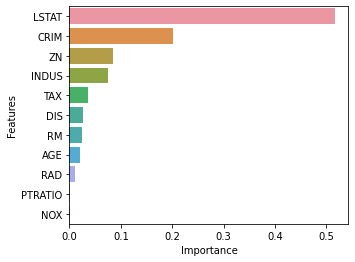

In [95]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 4))

In [96]:
y = (y_true).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
len(rules)

47

In [97]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

34     1
101    1
dtype: int64

In [98]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. CRIM <= 4.829776287078857 and ZN <= 21.74873638153076 and INDUS <= 24.95164966583252 and 2.4441553354263306 < LSTAT <= 9.98689317703247 [687, 9862]


In [99]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     18980
           1       0.90      0.98      0.94     13181

    accuracy                           0.95     32161
   macro avg       0.95      0.95      0.95     32161
weighted avg       0.95      0.95      0.95     32161



#### Evaluation

##### Global Fidelity

In [100]:
rclf = RuleClassifier(feature_names, rules)
evaluate_ruleclf(rclf, X, y_true)

              precision    recall  f1-score   support

       False       1.00      0.74      0.85       244
        True       0.03      1.00      0.06         2

    accuracy                           0.74       246
   macro avg       0.52      0.87      0.46       246
weighted avg       0.99      0.74      0.85       246



##### Counterfactual Fidelity Error

In [101]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [102]:
rmse

CRIM        3.004825
ZN         11.447177
INDUS       7.183708
NOX              NaN
RM               NaN
AGE              NaN
DIS              NaN
RAD              NaN
TAX              NaN
PTRATIO          NaN
LSTAT       3.157633
dtype: float64

In [103]:
boundary_miss_rate

CRIM       0.333333
ZN         0.000000
INDUS      0.500000
NOX             NaN
RM         1.000000
AGE        1.000000
DIS        1.000000
RAD        1.000000
TAX        1.000000
PTRATIO    1.000000
LSTAT      0.000000
dtype: float64

In [104]:
boundary_add_rate

CRIM       0.0
ZN         0.0
INDUS      0.0
NOX        NaN
RM         NaN
AGE        NaN
DIS        NaN
RAD        NaN
TAX        NaN
PTRATIO    NaN
LSTAT      0.0
dtype: float64

##### Complexity

In [105]:
get_complexity(constraints)

Number of rules: 1
Number of constraints: 5 (5.0 per rule)


### Local Explanation

In [112]:
%%time
train_surrogate_tree(explanation, max_depth=14)

CPU times: user 154 ms, sys: 4.03 ms, total: 158 ms
Wall time: 180 ms


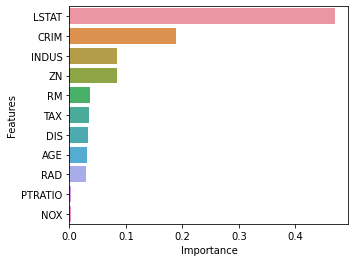

In [113]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 4))

In [114]:
y = (y_true).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
len(rules)

181

In [115]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

34     67
101     3
dtype: int64

In [116]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])
print_rules(rules, class_occurences)

1. CRIM <= 4.829776287078857 and -36.968496322631836 < ZN <= 21.74873638153076 and INDUS <= 17.2130184173584 and RM > 4.910179615020752 and RAD <= 2.9123259782791138 and 2.4441553354263306 < LSTAT <= 9.123514652252197 [61, 849]
2. CRIM <= 4.829776287078857 and -7.096050262451172 < ZN <= 21.74873638153076 and 7.862161874771118 < INDUS <= 24.95164966583252 and RM <= 4.910179615020752 and AGE > 1.2141383290290833 and RAD > 17.82404899597168 and 2.4441553354263306 < LSTAT <= 9.98689317703247 [0, 5]


In [117]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     18980
           1       0.96      0.99      0.98     13181

    accuracy                           0.98     32161
   macro avg       0.98      0.98      0.98     32161
weighted avg       0.98      0.98      0.98     32161



#### Evaluation

##### Global Fidelity

In [118]:
rclf = RuleClassifier(feature_names, rules)
evaluate_ruleclf(rclf, X, y_true)

              precision    recall  f1-score   support

       False       1.00      0.98      0.99       244
        True       0.33      1.00      0.50         2

    accuracy                           0.98       246
   macro avg       0.67      0.99      0.75       246
weighted avg       0.99      0.98      0.99       246



##### Counterfactual Fidelity Error

In [119]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [120]:
rmse

CRIM        3.004825
ZN         11.447177
INDUS       3.538981
NOX              NaN
RM          0.856336
AGE         0.214138
DIS              NaN
RAD         3.363404
TAX              NaN
PTRATIO          NaN
LSTAT       3.000236
dtype: float64

In [121]:
boundary_miss_rate

CRIM       0.333333
ZN         0.000000
INDUS      0.250000
NOX             NaN
RM         0.333333
AGE        0.500000
DIS        1.000000
RAD        0.000000
TAX        1.000000
PTRATIO    1.000000
LSTAT      0.000000
dtype: float64

In [122]:
boundary_add_rate

CRIM       0.0
ZN         0.5
INDUS      0.0
NOX        NaN
RM         0.0
AGE        0.0
DIS        NaN
RAD        0.0
TAX        NaN
PTRATIO    NaN
LSTAT      0.0
dtype: float64

##### Complexity

In [123]:
get_complexity(constraints)

Number of rules: 2
Number of constraints: 18 (9.0 per rule)
